## Clean data 

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from tqdm import tqdm_notebook

from itertools import product

In [96]:
DATAPATH = 'data/train.csv'

In [97]:
data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
data.head(10)

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:00,0,735.740043,54479.540513
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
2019-03-19 00:01:00,6,720.406875,47835.758121
2019-03-19 00:01:10,7,712.682269,47806.938481
2019-03-19 00:01:20,8,711.509741,47812.099044


In [98]:
data.shape

(564, 3)

In [99]:
data = data[1:]
data.shape
data

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
...,...,...,...
2019-03-19 01:33:10,559,423.726707,54115.388787
2019-03-19 01:33:20,560,424.278568,54127.830664
2019-03-19 01:33:30,561,420.127639,54092.561194


In [100]:
# -------------do not execute------------------#
# data = data.resample('20S').mean()
# print(data.shape)
# data

I dont think we have enough data to resample. On top of that, resampling (by 30s) is removing the AR and MA component... means... after resampling...we can simply use rolling average as predictor... I not intending to submit that quality work.. 

I will have good general accuracy, but will tend to higher RMSE compared to a more tuned ARIMA

Thus we shall not resample...

## Exploratory data analysis (EDA)

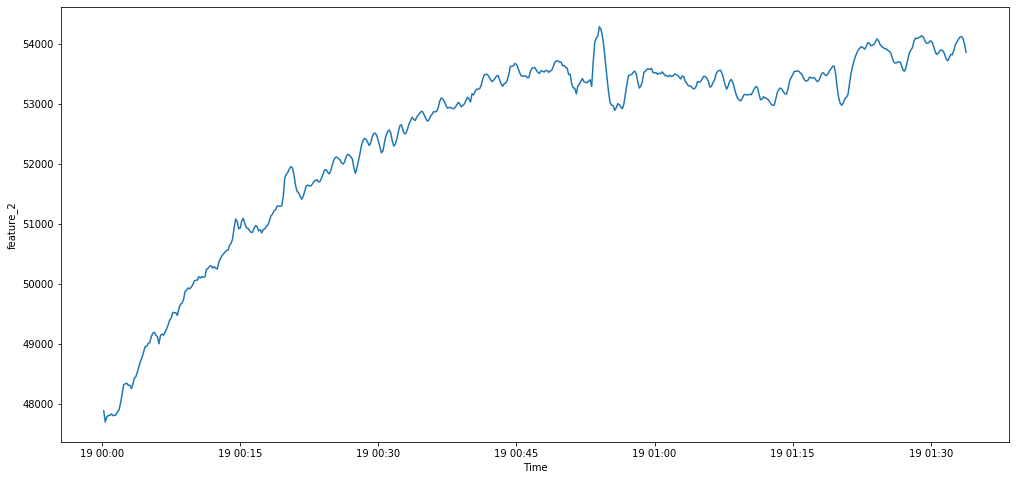

In [101]:
plt.figure(figsize=(17, 8))
plt.plot(data.feature_2)
plt.ylabel('feature_2')
plt.xlabel('Time')
plt.grid(False)
plt.show()

### Moving average

In [108]:
def plot_moving_average(series, window):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')       
#     plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

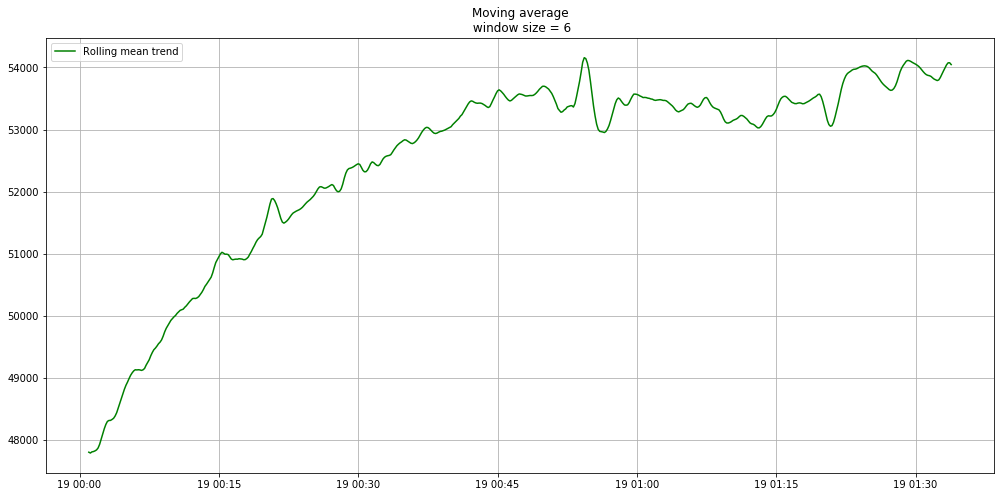

In [109]:
#Smooth by the previous 6 reading (10 seconds/1min)
plot_moving_average(data.feature_2,6)

## Decomp to understand Seasonality

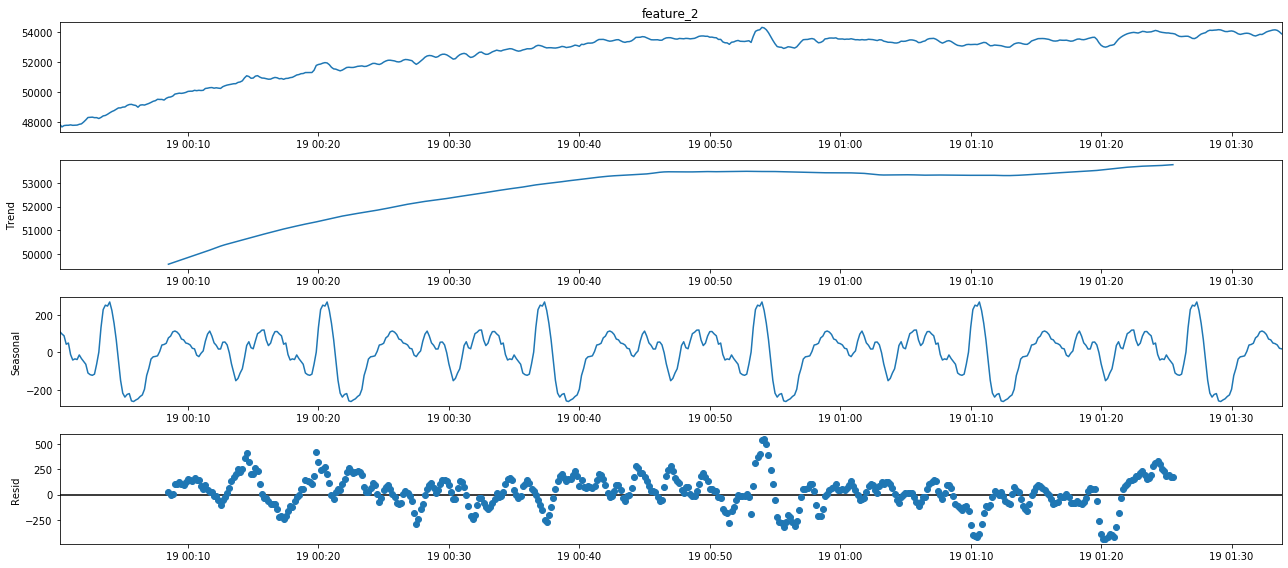

In [136]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.feature_2, model='additive', period=100)
fig = decomposition.plot()
plt.show()

Quenstion needs answering

With increase in seasonality there is an increase in residuals also... so there can be increasing seasonality doesnt reduce reseduals... this seasonality is being extracted at the cost of residual ?

## Stationarity 

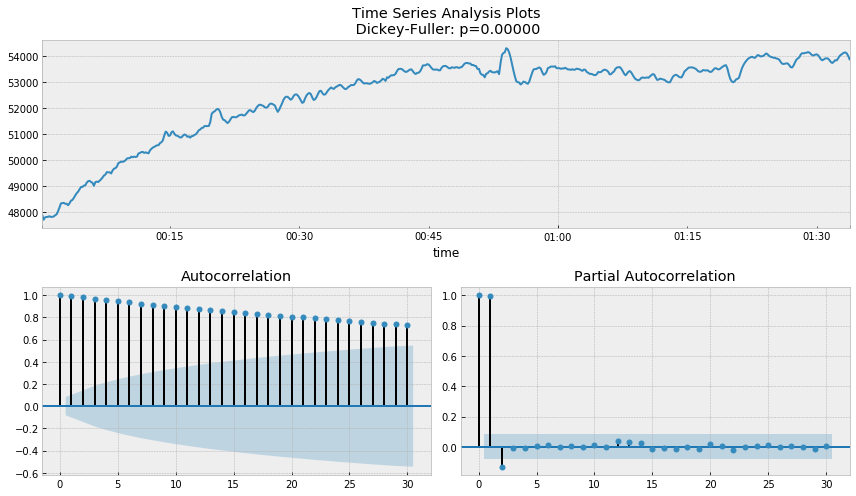

In [110]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.feature_2, lags=30)

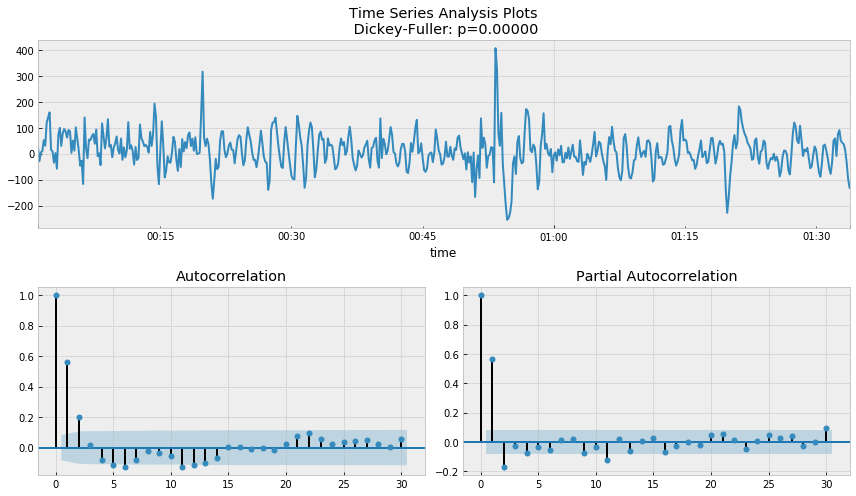

In [158]:
data_diff = data.feature_2 - data.feature_2.shift(1)

tsplot(data_diff[5:], lags=30)

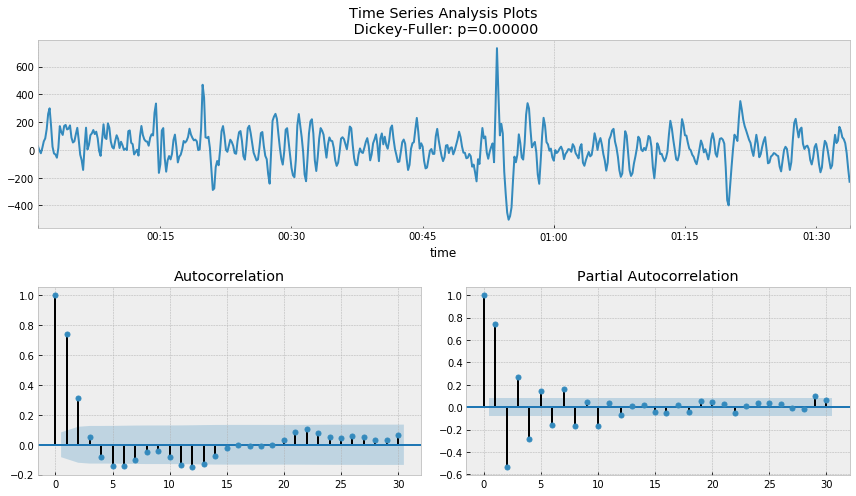

In [112]:
data_diff = data.feature_2 - data.feature_2.shift(2)

tsplot(data_diff[5:], lags=30)

at d = 2 -> q acts funny... I am a little unware when this situation arises

#### Predicted readings from the ACF and PACF graphs

* p-val = 0-2
* d = 1 or 2
* q = 0-2

## SARIMA

In [142]:
#Set initial values and some bounds
ps = range(0, 2)
d = 2
qs = range(0, 2)
Ps = range(0, 2)
D = 2
Qs = range(0, 2)
s = 10

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [144]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.feature_2, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

C:\Users\samla\anaconda3\lib\site-packages\ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Us

In [147]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.feature_2, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
C:\Users\samla\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                          feature_2   No. Observations:                  563
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 10)   Log Likelihood               -3106.436
Date:                            Wed, 15 Jul 2020   AIC                           6222.871
Time:                                    11:13:00   BIC                           6244.338
Sample:                                03-19-2019   HQIC                          6231.266
                                     - 03-19-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5788      0.037     15.686      0.000       0.507       0.651
ma.L1         -0.9999      2.546   

In [153]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'feature_2': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.feature_2.shape[0], end=data.feature_2.shape[0] + 5))
print(np.sqrt(mean_squared_error(data.feature_2[s+d:], best_model.fittedvalues[s+d:])))

2019-03-19 01:34:00    53768.293299
2019-03-19 01:34:10    53784.487020
2019-03-19 01:34:20    53828.176924
2019-03-19 01:34:30    53849.752144
2019-03-19 01:34:40    53857.971891
2019-03-19 01:34:50    53850.129502
Freq: 10S, dtype: float64
310.3216892397711
